# Demonstrate accessing UM N2560 5km RAL3 data from zarr on JASMIN object store

* First look at simulations for WCRP Hackathon UK Node.
* Can be run on JASMIN or anywhere else: set `on_jasmin`.
* Can fetch healpix zoom levels 10-0. Levels 8+ might be slow to load outside JASMIN.
* Tested using this Python conda env: https://github.com/digital-earths-global-hackathon/tools/blob/main/python_envs/environment.yaml (with some extra packages).
    * You can install with:
    * `wget https://raw.githubusercontent.com/digital-earths-global-hackathon/tools/refs/heads/main/python_envs/environment.yaml`
    * <edit last line of environment.yaml to be the name of your new env, e.g. hackathon_env>
    * `conda env create -f environment.yaml`
* Data is still experimental - problem with processing means it uses float64 instead of float32. Haven't properly tested time alignment yet.
* Not all variables in the standard protocol are present - I have included those that are.
* I believe there is a plotting issue at lon=0 - and that data is OK.
* Contact mark.muetzelfeldt@reading.ac.uk for more info.

There are two stores for each zoom level, one for 2D and one for 3D variables, and the 2D dataset has two time coordinates, one on the hour (`time`) for instantaneous fields, and one half past the hour (`time_halfpast`) for hourly mean data. The data is from the simulation UM N2560 5km RAL3, i.e. using approx. 5km grid spacing and the Met Office's Regional Atmosphere Land 3 science settings.

A note on chunking: I am storing the data with chunks `(1, n_healpix_cell)` (time, cells) because of the way I am outputting the data to zarr and the UM data is stored in its output files. I am using [xarray zarr distributes writes](https://docs.xarray.dev/en/stable/user-guide/io.html#distributed-writes) to write from SLURM jobs in parallel for each unit of work (i.e. one UM output file). Each UM output file is for 12-h, but some variables are output at the start of each hour, some at the end. This means I cannot easily write to larger than 1-h chunks because I want to have one consistent time coordinate, and writing to larger than 1-h would necessarily not align with the chunk boundaries. A consequence is that producing a time series from e.g. zoom level 0 will involve approx. 365 * 24 separate file downloads, one for each chunk in the time dimension. Is this acceptable? I think the chunking for zoom level 10 is OK because there's far more spatial data per chunk.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import easygems.healpix as egh

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /opt/conda/analysis3-25.03/lib/gdalplugins/../libgdal.so.36)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /opt/conda/analysis3-25.03/lib/gdalplugins/../libgdal.so.36)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /opt/conda/analysis3-25.03/lib/gdalplugins/../libgdal.so.36)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /opt/conda/analysis3-25.03/lib/gdalplugins/../libgdal.so.36)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pyproj/../../..

In [4]:
ds2d = xr.open_zarr('/scratch/gb02/sg7549/jasmin_tests/UK_models/data.2d.z4.zarr')
ds2d

<xarray.Dataset> Size: 6GB
Dimensions:        (cell: 3072, time: 9745, time_halfpast: 9744)
Coordinates:
  * cell           (cell) int64 25kB 0 1 2 3 4 5 ... 3067 3068 3069 3070 3071
  * time           (time) datetime64[ns] 78kB 2020-01-20 ... 2021-03-01
  * time_halfpast  (time_halfpast) datetime64[ns] 78kB 2020-01-20T00:30:00 .....
Data variables: (12/24)
    clivi          (time, cell) float64 239MB dask.array<chunksize=(1, 3072), meta=np.ndarray>
    clt            (time, cell) float64 239MB dask.array<chunksize=(1, 3072), meta=np.ndarray>
    clwvi          (time, cell) float64 239MB dask.array<chunksize=(1, 3072), meta=np.ndarray>
    hflsd          (time, cell) float64 239MB dask.array<chunksize=(1, 3072), meta=np.ndarray>
    hfssd          (time, cell) float64 239MB dask.array<chunksize=(1, 3072), meta=np.ndarray>
    huss           (time, cell) float64 239MB dask.array<chunksize=(1, 3072), meta=np.ndarray>
    ...             ...
    rsut           (time, cell) float64 239MB dask.array<chunksize=(1, 3072), meta=np.ndarray>
    rsutcs         (time, cell) float64 239MB dask.array<chunksize=(1, 3072), meta=np.ndarray>
    tas            (time, cell) float64 239MB dask.array<chunksize=(1, 3072), meta=np.ndarray>
    ts             (time, cell) float64 239MB dask.array<chunksize=(1, 3072), meta=np.ndarray>
    uas            (time, cell) float64 239MB dask.array<chunksize=(1, 3072), meta=np.ndarray>
    vas            (time, cell) float64 239MB dask.array<chunksize=(1, 3072), meta=np.ndarray>

In [5]:
def plot_all_fields_2d(ds_plot, zoom, time_idx):

    projection = ccrs.Robinson(central_longitude=0)
    
    fig, axes = plt.subplots(6, 4, figsize=(30, 20), subplot_kw={'projection': projection}, layout='constrained')
    plt.suptitle(f'UM N2560 RAL3 healpix zoom={zoom}')
    
    for ax, (name, da) in zip(axes.flatten(), ds_plot.data_vars.items()):
        print(name)
        timename = [c for c in da.coords if c.startswith('time')][0]
        time = pd.Timestamp(ds_plot[timename].values[time_idx])
    
        data = da.isel(**{timename: time_idx})
        ax.set_title(f'{timename}: {time} - {name}')
        ax.set_global()
        im = egh.healpix_show(data.values, ax=ax);
        long_name = da.long_name
            
        plt.colorbar(im, label=f'{long_name} ({da.attrs.get("units", "-")})')
        ax.coastlines()

clivi
clt
clwvi
hflsd
hfssd
huss
pr
prs
prw
ps
psl
rldscs
rldt
rlut
rlutcs
rsds
rsdscs
rsdt
rsut
rsutcs
tas
ts
uas
vas


ERROR:fiona._env:/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /opt/conda/analysis3-25.03/lib/gdalplugins/../libgdal.so.36)
ERROR:fiona._env:/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /opt/conda/analysis3-25.03/lib/gdalplugins/../libgdal.so.36)
ERROR:fiona._env:/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /opt/conda/analysis3-25.03/lib/gdalplugins/../libgdal.so.36)
ERROR:fiona._env:/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /opt/conda/analysis3-25.03/lib/gdalplugins/../libgdal.so.36)
ERROR:fiona._env:/g/data/hh5/pub

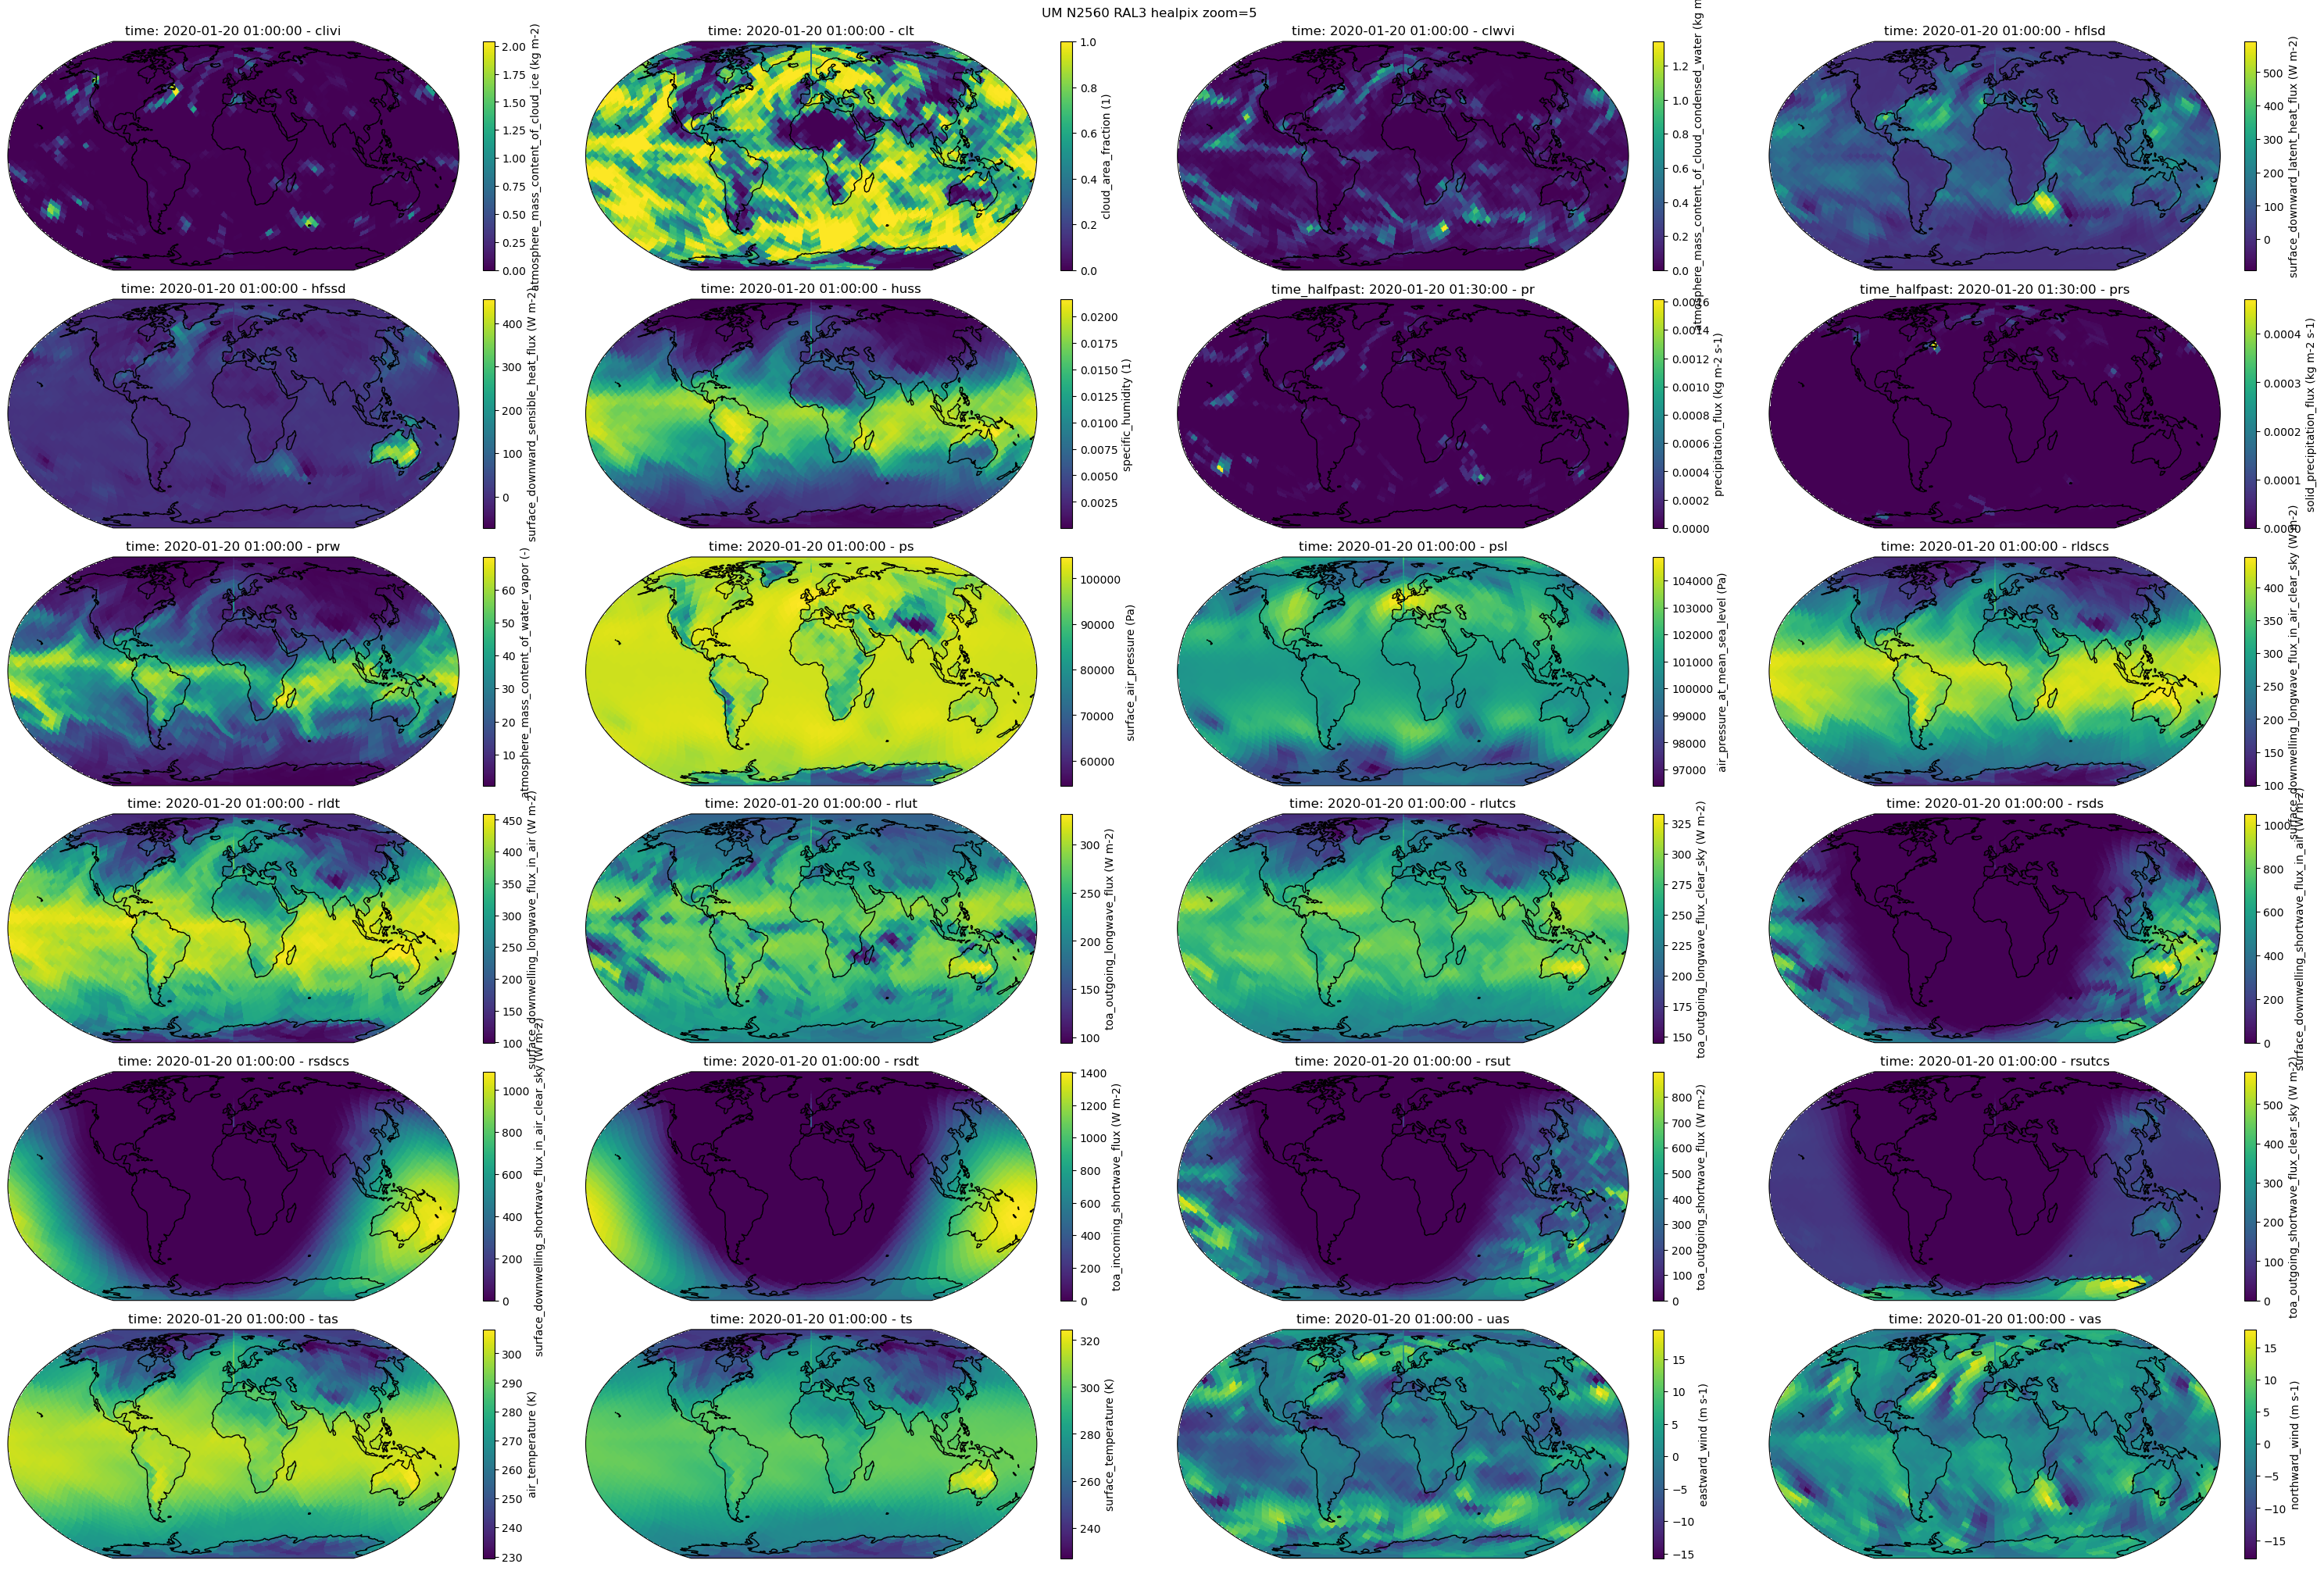

In [6]:
plot_all_fields_2d(ds2d, 5, 1)

In [8]:
data_3d = "/scratch/gb02/sg7549/jasmin_tests/UK_models/data.healpix.PT3H.z6.zarr"
ds3d = xr.open_zarr(data_3d)
ds3d

<xarray.Dataset> Size: 206GB
Dimensions:   (cell: 49152, time: 3497, pressure: 25)
Coordinates:
  * cell      (cell) int64 393kB 0 1 2 3 4 5 ... 49147 49148 49149 49150 49151
    crs       float64 8B ...
  * pressure  (pressure) int64 200B 1 5 10 20 30 50 ... 875 900 925 950 975 1000
  * time      (time) datetime64[ns] 28kB 2020-01-20 ... 2021-04-01
Data variables:
    cli       (time, pressure, cell) float32 17GB dask.array<chunksize=(64, 1, 16384), meta=np.ndarray>
    clw       (time, pressure, cell) float32 17GB dask.array<chunksize=(64, 1, 16384), meta=np.ndarray>
    hur       (time, pressure, cell) float32 17GB dask.array<chunksize=(64, 1, 16384), meta=np.ndarray>
    hus       (time, pressure, cell) float32 17GB dask.array<chunksize=(64, 1, 16384), meta=np.ndarray>
    qg        (time, pressure, cell) float32 17GB dask.array<chunksize=(64, 1, 16384), meta=np.ndarray>
    qr        (time, pressure, cell) float32 17GB dask.array<chunksize=(64, 1, 16384), meta=np.ndarray>
    qs        (time, pressure, cell) float32 17GB dask.array<chunksize=(64, 1, 16384), meta=np.ndarray>
    ta        (time, pressure, cell) float32 17GB dask.array<chunksize=(64, 1, 16384), meta=np.ndarray>
    ua        (time, pressure, cell) float32 17GB dask.array<chunksize=(64, 1, 16384), meta=np.ndarray>
    va        (time, pressure, cell) float32 17GB dask.array<chunksize=(64, 1, 16384), meta=np.ndarray>
    wa        (time, pressure, cell) float32 17GB dask.array<chunksize=(64, 1, 16384), meta=np.ndarray>
    zg        (time, pressure, cell) float32 17GB dask.array<chunksize=(64, 1, 16384), meta=np.ndarray>
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n2560_RAL3p3
    simulation_description:           The MetUM uses a regular lat-lon grid, ...

In [9]:
def plot_all_fields_3d(ds_plot, zoom, time_idx, pressure):

    projection = ccrs.Robinson(central_longitude=0)
    
    fig, axes = plt.subplots(3, 4, figsize=(30, 10), subplot_kw={'projection': projection}, layout='constrained')
    plt.suptitle(f'UM N2560 RAL3 healpix zoom={zoom} @ {pressure} hPa')
    
    for ax, (name, da) in zip(axes.flatten(), ds_plot.data_vars.items()):
        print(name)
        timename = [c for c in da.coords if c.startswith('time')][0]
        time = pd.Timestamp(ds_plot[timename].values[time_idx])
    
        data = da.isel(**{timename: time_idx}).sel(pressure=pressure) 
        ax.set_title(f'{timename}: {time} - {name}')
        ax.set_global()
        im = egh.healpix_show(data.values, ax=ax);
        long_name = da.long_name
            
        plt.colorbar(im, label=f'{long_name} ({da.attrs.get("units", "-")})')
        ax.coastlines()

cli
clw
hur
hus
qg
qr
qs
ta
ua
va
wa
zg


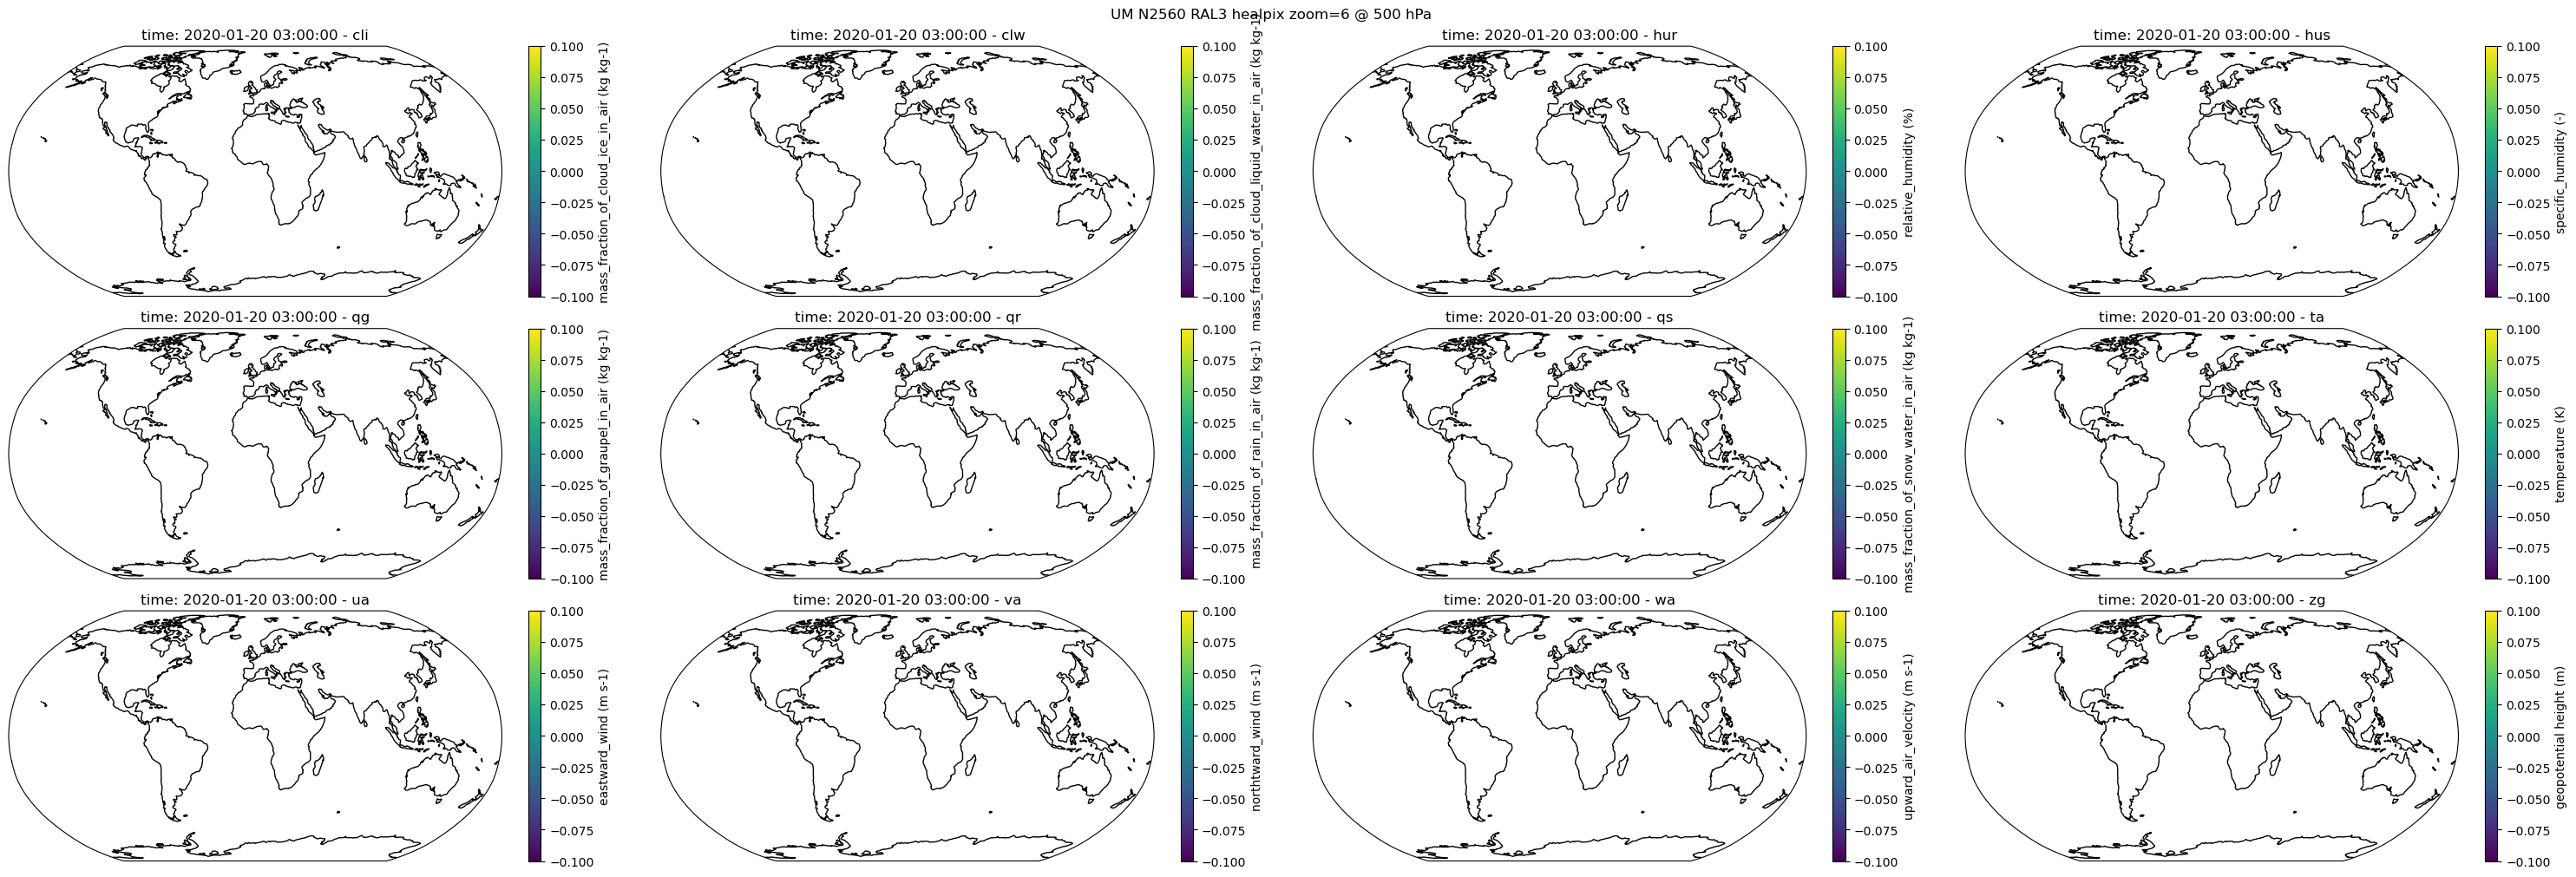

In [14]:
plot_all_fields_3d(ds3d, 6, 1, 500)

In [13]:
ds3d.cli[0][0]

<xarray.DataArray 'cli' (cell: 49152)> Size: 197kB
dask.array<getitem, shape=(49152,), dtype=float32, chunksize=(16384,), chunktype=numpy.ndarray>
Coordinates:
  * cell      (cell) int64 393kB 0 1 2 3 4 5 ... 49147 49148 49149 49150 49151
    crs       float64 8B ...
    pressure  int64 8B 1
    time      datetime64[ns] 8B 2020-01-20
Attributes:
    STASH:          [1, 0, 12]
    UM_name:        mass_fraction_of_cloud_ice_in_air
    grid_mapping:   healpix_nested
    healpix_zoom:   6
    long_name:      mass_fraction_of_cloud_ice_in_air
    notes:          interpolated from UM model levels to pressure levels usin...
    source:         Data from Met Office Unified Model
    standard_name:  mass_fraction_of_cloud_ice_in_air
    um_version:     13.5
    units:          kg kg-1